# Introduction: CM vs MN BPNet model training and grid searching

The purpose of this notebook is to to train a model on cardiac progenitor and motor neuron progenitor ChIP-seq samples that have been ChIPed for ISL1. We will train a series of models based on targeted parameter searching in order to optimize the settings to be the best possible outputs prior to running TF-MoDISco and performing downstream interpretations. We will use counts correlation scores and auPRC profile classification of summits to determine which combination of parameters are the best. 

# Computational Setup

In [1]:
# Configurations
import warnings;warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation; deprecation._PRINT_DEPRECATION_WARNINGS = False

#Modules
import os
import sys
import yaml
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotnine
from glob import glob
from plotnine import *
from itertools import product, compress
from pybedtools import BedTool
from keras import backend as K
from bpnet.utils import read_json, create_tf_session
from bpnet.dataspecs import DataSpec
from bpnet.datasets import StrandedProfile
from bpnet.extractors import StrandedBigWigExtractor
from bpnet.BPNet import BPNetSeqModel
from bpnet.metrics import eval_profile

#Setup
os.chdir('/n/projects/mw2098/publications/2022_maven_ISL1/')
create_tf_session('0', .5)
%matplotlib inline

#Variables
dataspec = DataSpec.load(f'dataspec/dataspec.yml')
config = read_json(f'models/seq_width1000-lr0.001-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters64/config.gin.json')
tasks = list(dataspec.task_specs.keys())

with open(r'yml/CM_vs_MN_replicates.yml') as file:
    rep_path_dict = yaml.load(file, Loader=yaml.FullLoader)
[[os.path.exists(v2) for k2,v2 in v1.items()] for k1,v1 in rep_path_dict.items()]

Using TensorFlow backend.
2022-01-10 09:29:52,722 [WARNING] git-lfs not installed
2022-01-10 09:29:52,906 [INFO] Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2022-01-10 09:29:52,908 [INFO] Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-01-10 09:29:52,909 [INFO] NumExpr defaulting to 8 threads.


[[True, True], [True, True], [True, True]]

In [2]:
!mkdir -p figures/1_model_training_and_grid_search

# Filter given 

In R, run the following commands in order to remove regions that are on the edges of chromosome boundaries.

In [3]:
%%script false --no-raise-error
source('')
rtracklayer::import('bed/I_wt_d6cm_consensus.bed') %>%
  check_chromosome_boundaries(., 5000, genome = BSgenome.Hsapiens.UCSC.hg19) %>%
  rtracklayer::export(., 'bed/I_wt_d6cm_consensus_filtered.bed')
rtracklayer::import('bed/I_wt_s3mn_consensus.bed') %>%
  check_chromosome_boundaries(., 5000, genome = BSgenome.Hsapiens.UCSC.hg19) %>%
  rtracklayer::export(., 'bed/I_wt_s3mn_consensus_filtered.bed')

# Address single-bias track

Because the original BPNet repository requires only 1 bias track to be used, we merged the WCE input control reads from CM and MN samples to use them as the single bias track. Below is the command used to merge these samples. 

We investigated both the CM and MN input control samples in order to determine that they did not exibit any cell-specific bias that might indicate that these control samples could not be merged. It was determined that they provide background input information, but that this information was not cell type-specific, especially at sites of high and differential binding in the ISL1 ChIP-seq experimental samples.

In [4]:
%%script false --no-raise-error
!Rscript scripts/merge_bigwigs.r --files=data/bw/combined/input_wt_*.bw --output=data/bw/combined/input_wt_merged.bw --bsgenome=BSgenome.Hsapiens.UCSC.hg19 --cores 2

## Helper functions

To read the evaluation metrics computed in the training step of BPNet, we need to parse through a `.json` file.

In [5]:
def collect_eval_metrics(eval_path):
    from bpnet.utils import read_json
    eval_dict = read_json(eval_path)
    df = pd.DataFrame([(k,k1,v1) for k,v in eval_dict.items() for k1,v1 in v.items()], columns = ['dataset','id','value'])
    df = df.replace({'counts/':'counts//'}, regex=True) 
    df[['task','head','binsize','metric']] = df.id.str.split('/', expand=True) 
    df[(df['metric']=='auprc') | (df['metric']=='spearmanr')]
    return(df)

Modify the auPRC measurements from `bpnet.metrics` in order to accommodate ChIP-seq single-channel tracks. Keep in mind threshold values should be fundamentally different from ChIP-nexus data.

In [6]:
def bin_seq_counts_amb(x, binsize=2):
    """Bin the counts
    """
    if binsize == 1:
        return x
    outlen = x.shape[1] // binsize
    xout = np.zeros((x.shape[0], outlen)).astype(float)
    for i in range(outlen):
        iterval = x[:, (binsize * i):(binsize * (i + 1))]
        has_amb = np.any(iterval == -1, axis=1)
        has_peak = np.any(iterval == 1, axis=1)
        # if no peak and has_amb -> -1
        # if no peak and no has_amb -> 0
        # if peak -> 1
        xout[:, i] = (has_peak - (1 - has_peak) * has_amb).astype(float).flatten()
    return xout


def eval_seq_profile(yt, yp,
                 pos_min_threshold=0.05,
                 neg_max_threshold=0.01,
                 required_min_pos_counts=2.5,
                 binsizes=[1, 2, 4, 10]):
    import sklearn.metrics as skm
    import logging
    import matplotlib.pyplot as plt
    from bpnet.utils import read_pkl
    from keras.models import load_model
    from bpnet.utils import _listify, create_tf_session
    from bpnet.stats import permute_array
    from bpnet.functions import softmax, mean
    import os
    import json
    from tqdm import tqdm
    import matplotlib
    import pandas as pd
    import numpy as np
    from collections import OrderedDict
    from bpnet.metrics import bin_counts_amb,bin_counts_max,auprc
    import gin
    """
    Evaluate the profile in terms of auPR
    Args:
      yt: true profile (counts)
      yp: predicted profile (fractions)
      pos_min_threshold: fraction threshold above which the position is
         considered to be a positive
      neg_max_threshold: fraction threshold bellow which the position is
         considered to be a negative
      required_min_pos_counts: smallest number of reads the peak should be
         supported by. All regions where 0.05 of the total reads would be
         less than required_min_pos_counts are excluded
    """
    # The filtering
    # criterion assures that each position in the positive class is
    # supported by at least required_min_pos_counts  of reads
    do_eval = (yt.mean(axis=1) > required_min_pos_counts / pos_min_threshold).flatten()
    # make sure everything sums to one
    yp = (yp / yp.sum(axis=1, keepdims=True))
    fracs = (yt / yt.sum(axis=1, keepdims=True))
    yp_random = permute_array(permute_array(yp[do_eval], axis=1), axis=0)
    
    out = []
    for binsize in binsizes:
        is_peak = (fracs >= pos_min_threshold).astype(float)
        ambigous = (fracs < pos_min_threshold) & (fracs >= neg_max_threshold)
        is_peak[ambigous] = -1
        #y_true = np.ravel(bin_seq_counts_amb(is_peak[do_eval], binsize))
        y_true = bin_seq_counts_amb(is_peak[do_eval], binsize)
        imbalance = np.sum(y_true == 1) / np.sum(y_true >= 0)
        n_positives = np.sum(y_true == 1)
        n_ambigous = np.sum(y_true == -1)
        frac_ambigous = n_ambigous / y_true.size

        # TODO - I used to have bin_counts_max over here instead of bin_counts_sum
        try:
            res = auprc(y_true,
                        bin_counts_max(yp[do_eval], binsize))
            res_random = auprc(y_true,
                               bin_counts_max(yp_random, binsize))
        except Exception:
            res = np.nan
            res_random = np.nan

        out.append({"binsize": binsize,
                    "auprc": res,
                    "random_auprc": res_random,
                    "n_positives": n_positives,
                    "frac_ambigous": frac_ambigous,
                    "imbalance": imbalance
                    })

    return pd.DataFrame.from_dict(out)

# Parameter assessment

Here, we aim to look at several parameters:

1. `number of filters`
2. `learning rate`
3. `lambda value weighting the count loss to the profile loss`
4. `number of dilational layers`


1-4 we will assess in an "independent fashion" e.g. how well each deviates from the default settings. 

## Assessing parameters independently

Number of filters, learning rate, and lambda can be assessed in an independent fashion relative to the recommended defaults.

In [7]:
%%script false --no-raise-error
!python scripts/bpnet_train_as_grid_search.py --dataspec dataspec/dataspec.yml \
--config config/default.gin --output-directory models/ -x .4 --manually-run \
--filters '64' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '7' --loss-weight '100' \
--learning-rate '0.01,0.004,0.001,0.0004' --seq-width '1000'

!python scripts/bpnet_train_as_grid_search.py --dataspec dataspec/dataspec.yml \
--config config/default.gin --output-directory models/ -x .4 --manually-run \
--filters '64' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '7' --loss-weight '1,10,100,250,500,1000' \
--learning-rate '0.001' --seq-width '1000'

!python scripts/bpnet_train_as_grid_search.py --dataspec dataspec/dataspec.yml \
--config config/default.gin --output-directory models/ -x .4 --manually-run \
--filters '16,64,128,256,512' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '7' --loss-weight '100' \
--learning-rate '0.001' --seq-width '1000'

!python scripts/bpnet_train_as_grid_search.py --dataspec dataspec/dataspec.yml \
--config config/default.gin --output-directory models/ -x .4 --manually-run \
--filters '64' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '5,7,9,11' --loss-weight '100' \
--learning-rate '0.001' --seq-width '1000'

Below is a function that plots auPRC and spearman counts correlation to assess differences in tasks across various parameter selections.

In [8]:
def plot_independent_assessment(glob_str, parameter, output_plot_prefix, model_dir='models/'):
    #Collect evaluation metrics
    evals_path = glob(os.path.join(model_dir, glob_str))
    evals_dict = {i.split('/')[1]: collect_eval_metrics(i) for i in evals_path}

    #Convert to pd.df
    evals_df = pd.DataFrame()
    for k,v in evals_dict.items():
        v['model'] = k
        evals_df = evals_df.append(v)

    #Integrate model information
    model_params = ['seq_width','lr','lambda','n_dil_layers','conv_kernal_size','tconv_kernel_size','filters']
    evals_df[model_params] = evals_df.model.str.split('-', expand=True)
    model_params = model_params + ['binsize']
    evals_df[model_params] = evals_df[model_params].replace('[-+A-Za-z]','', regex = True).replace('_','', regex = True).replace('=','', regex = True)
    evals_df[model_params] = evals_df[model_params].apply(pd.to_numeric, errors='coerce', axis=1)

    #Create categorical value
    evals_df[parameter] = pd.Categorical(evals_df[parameter], 
                                      categories=evals_df.sort_values([parameter])[parameter].unique(), 
                                      ordered=True)
    
    #Plot Spearman correlation coefficient
    plotnine.options.figure_size = (20,3)

    spearmanr_plot = (ggplot(data = evals_df[evals_df['metric']=='spearmanr'], mapping = aes(x = 'dataset', y = 'value', fill=parameter))+
        geom_bar(stat = 'identity', position = 'dodge')+
        facet_grid('. ~ task')+
        scale_y_continuous(name = 'Cor')+
        ggtitle('Counts correlation (spearman)')+
        theme_classic())
    spearmanr_plot.save(f'{output_plot_prefix}_counts_valid_regions.png', height = 3, width = 16)
    spearmanr_plot.save(f'{output_plot_prefix}_counts_valid_regions.pdf', height = 3, width = 16)
    print(spearmanr_plot)
    
    plotnine.options.figure_size = (15,4)

    auprc_plot = (ggplot(data = evals_df[(evals_df['metric']=='auprc')], 
                                 mapping = aes(x = 'binsize', y = 'value', color=parameter))+
        geom_line()+
        facet_grid('dataset ~ task')+
        scale_y_continuous(name = 'auPRC')+
        ggtitle('auPRC of observed versus predicted')+
        theme_classic())
    auprc_plot.save(f'{output_plot_prefix}_profile_valid_regions.png', height = 3, width = 16)
    auprc_plot.save(f'{output_plot_prefix}_profile_valid_regions.pdf', height = 3, width = 16)
    print(auprc_plot)

### Filters

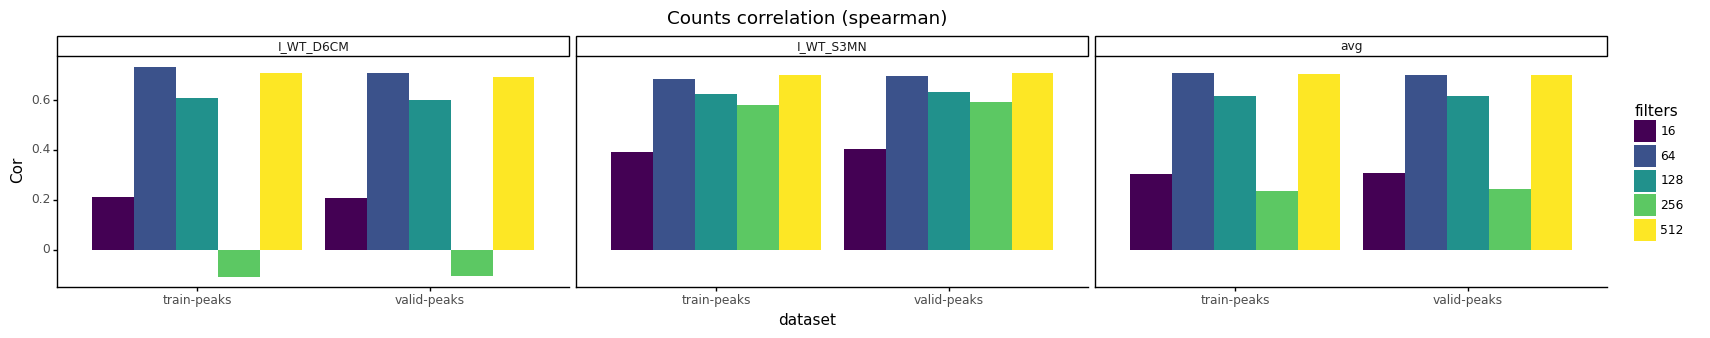

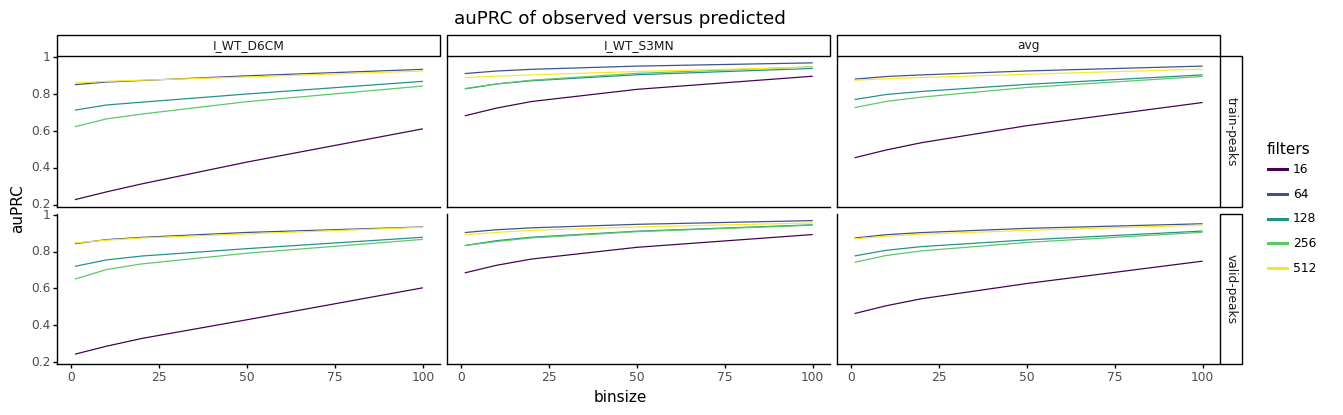

In [9]:
plot_independent_assessment(glob_str = 'seq_width1000-lr0.001-lambda100-n_dil_layers7-conv_kernel_size7-tconv_kernel_size7-filters*/evaluation.valid.json',
                           parameter = 'filters', model_dir = f'models/', output_plot_prefix = f'figures/1_model_training_and_grid_search/grid_search_filters')

### Learning rate

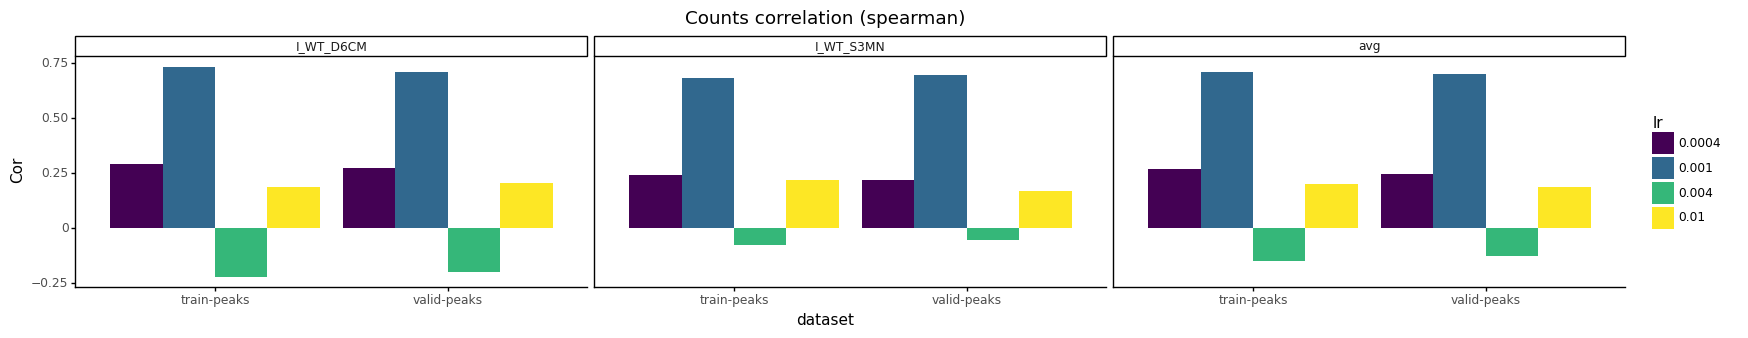

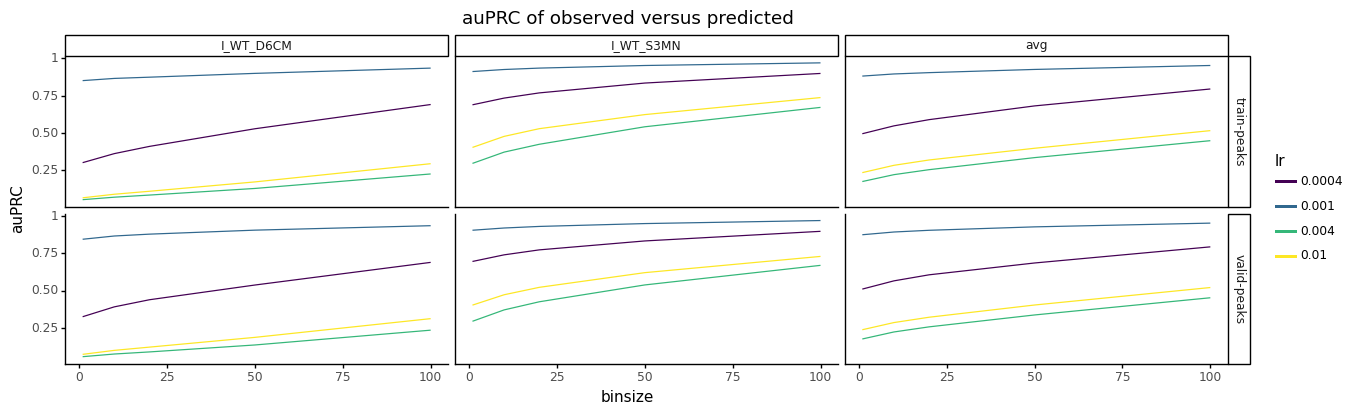

In [10]:
plot_independent_assessment(glob_str = 'seq_width1000-lr*-lambda100-n_dil_layers7-conv_kernel_size7-tconv_kernel_size7-filters64/evaluation.valid.json',
                           parameter = 'lr', model_dir = f'models/', output_plot_prefix = f'figures/1_model_training_and_grid_search/grid_search_lr')

## Lambda

Keep in mind that lambda might be different depending on the distribution reads in each sample. However, for each model we can manually compute that discrepancy to get a good idea of the correction ratio that is recommended.

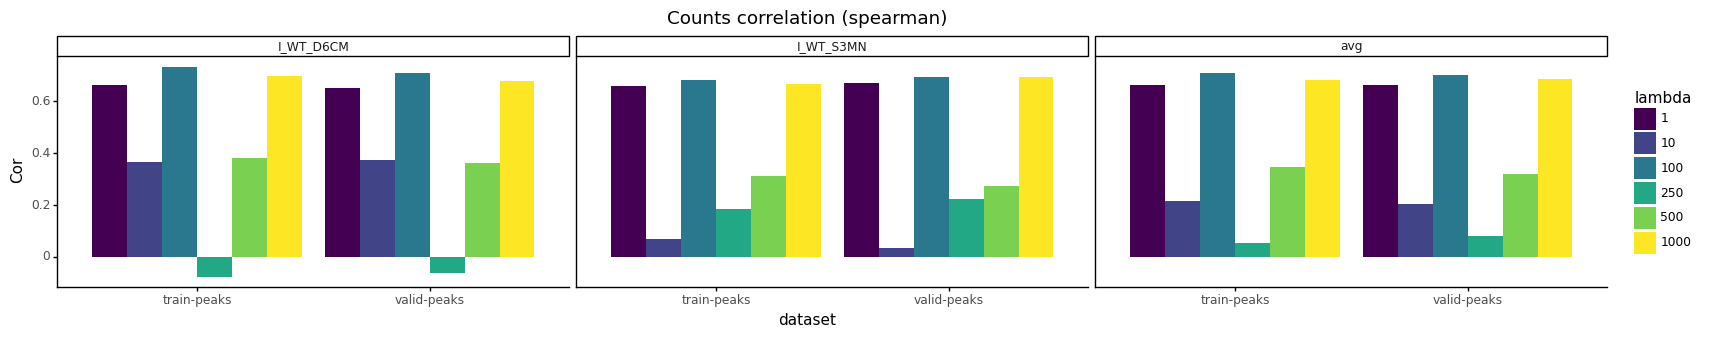

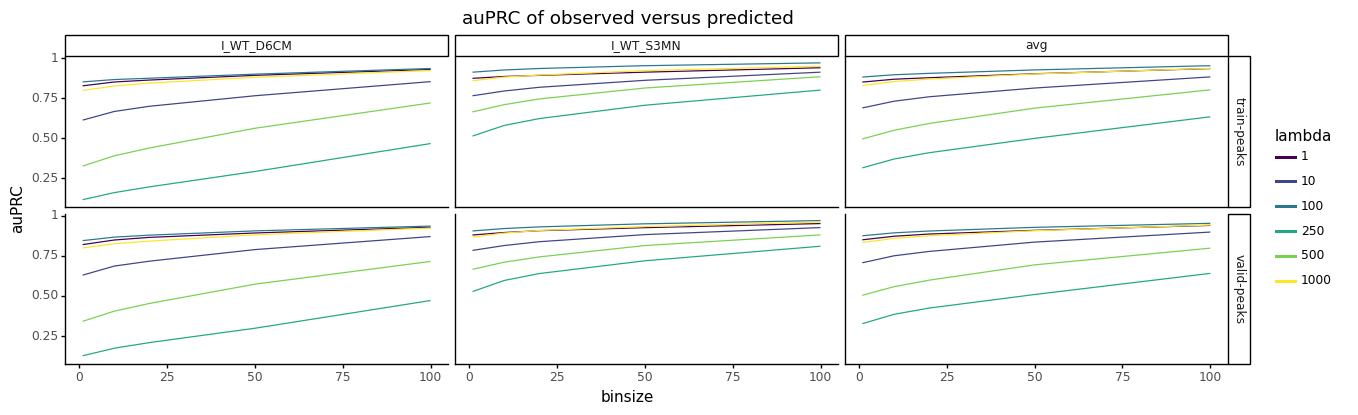

In [11]:
plot_independent_assessment(glob_str = 'seq_width1000-lr0.001-lambda*-n_dil_layers7-conv_kernel_size7-tconv_kernel_size7-filters64/evaluation.valid.json',
                           parameter = 'lambda', model_dir = f'models/', output_plot_prefix = f'figures/1_model_training_and_grid_search/grid_search_lambda')

Compute average ratio of "counts loss to profile loss" that each lambda would recall.

In [12]:
#Collect evaluation metrics
evals_path = glob(os.path.join(f'models/', 'seq_width1000-lr0.004-lambda*-n_dil_layers7-conv_kernel_size7-tconv_kernel_size7-filters64/history.csv'))
evals_dict = {i.split('/')[1]: pd.read_csv(i) for i in evals_path}

#Convert to pd.df
evals_df = pd.DataFrame()
for k,v in evals_dict.items():
    v['model'] = k
    evals_df = evals_df.append(v)
    
#Integrate model information
model_params = ['seq_width','lr','lambda','n_dil_layers','conv_kernal_size','tconv_kernel_size','filters']
evals_df[model_params] = evals_df.model.str.split('-', expand=True)
evals_df[model_params] = evals_df[model_params].replace('[-+A-Za-z]','', regex = True).replace('_','', regex = True).replace('=','', regex = True)
evals_df[model_params] = evals_df[model_params].apply(pd.to_numeric, errors='coerce', axis=1)

#Return columns belonging to profile and counts
profile_columns = [f'{t}/profile_loss' for t in tasks] + ['lambda']
counts_columns = [f'{t}/counts_loss' for t in tasks] + ['lambda']

avg_profile_loss = evals_df[profile_columns].groupby(['lambda']).mean().mean(axis=1)
avg_counts_loss = evals_df[counts_columns].groupby(['lambda']).mean().mean(axis = 1)

print("The average ratio of profile loss : counts_loss* lambda is:")
avg_profile_loss/(avg_counts_loss*avg_counts_loss.index)

The average ratio of profile loss : counts_loss* lambda is:


lambda
1.0       20204.477573
10.0        878.087858
100.0       106.069657
250.0       411.243074
500.0       270.621006
1000.0      232.539333
dtype: float64

Here, this means that when you want a good balance of profile:counts loss, measure lambda such that you're getting anywhere from (10:100):1. It seems like values within these ratios are optimal for improving counts predictions without sacrificing loss. Keep in mind that the loss is related to the number of reads in the samples given, so the lambda value might need to be different to accommodate the loss values.

## Number of dilational layers

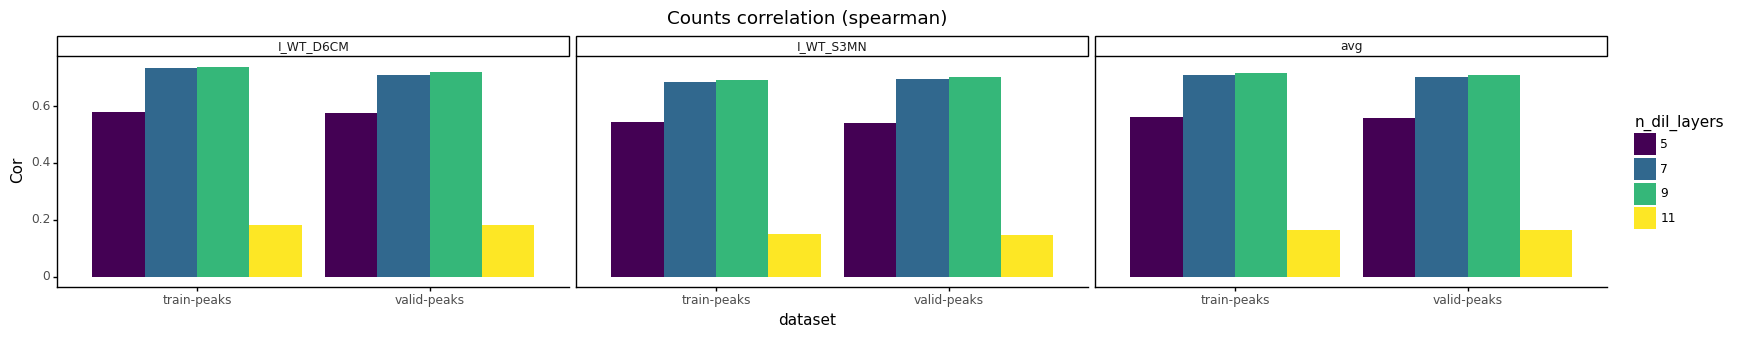

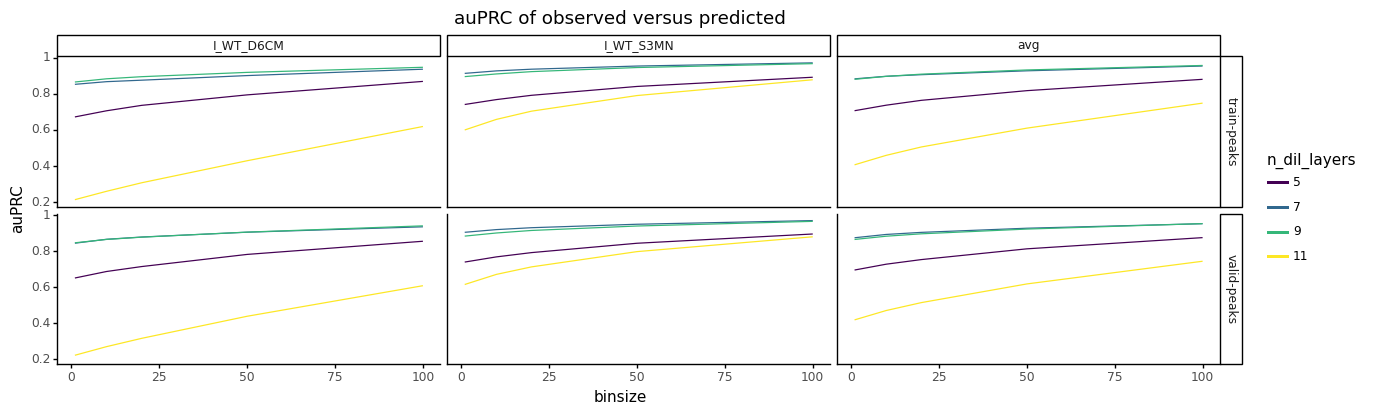

In [13]:
plot_independent_assessment(glob_str = 'seq_width1000-lr0.001-lambda100-n_dil_layers*-conv_kernel_size7-tconv_kernel_size7-filters64/evaluation.valid.json',
                           parameter = 'n_dil_layers', model_dir = f'models/', output_plot_prefix = f'figures/1_model_training_and_grid_search/grid_search_ndil')

# Train final model with best specs

The model that performed best in was: `seq_width1000-lr0.001-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters64`. Given these hyperparameters, generate a model.

In [14]:
%%script false --no-raise-error
!python /n/projects/mw2098/shared_code/bpnet/bpnet_train_as_grid_search.py --dataspec dataspec/{prefix}_dataspec.yml \
--config config/default.gin --output-directory models/{prefix}/ -x .7 --manually-run \
--filters '64' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '9' --loss-weight '100' \
--learning-rate '0.001' --seq-width '1000'

# Comparison of best model with observed/replicate quality metrics 

Load the model `models/CM_vs_MN_merged_bias_exp_peaks/seq_width1000-lr0.001-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters64` into this session.

In [15]:
K.clear_session()
create_tf_session('0', .5)

model = BPNetSeqModel.from_mdir(f'models/seq_width1000-lr0.001-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters64')

TF-MoDISco is using the TensorFlow backend.


## Collect coverage from predictions, observed, and replicate values

Here, we want to compare replicate and metapeak quality metrics with the models trained below. Keep in mind that we will remove regions not associated with each task in order to ensure that we aren't predicting regions that are not of interest for particular tasks.

First, collect data and regions for coverage extraction.

In [16]:
excl_chromosomes = config['bpnet_data.exclude_chr']
valid_chromosomes = config['bpnet_data.valid_chr']
test_chromosomes = config['bpnet_data.test_chr']

In [17]:
train_dl = StrandedProfile(dataspec, 
                     excl_chromosomes = excl_chromosomes + valid_chromosomes + test_chromosomes, 
                     peak_width=config['bpnet_data.peak_width'],
                     seq_width=config['bpnet_data.seq_width'],
                     shuffle=False)
valid_dl = StrandedProfile(dataspec, 
                     incl_chromosomes = valid_chromosomes, 
                     excl_chromosomes = excl_chromosomes, 
                     peak_width=config['bpnet_data.peak_width'],
                     seq_width=config['bpnet_data.seq_width'],
                     shuffle=False)
test_dl = StrandedProfile(dataspec, 
                     incl_chromosomes = test_chromosomes, 
                     excl_chromosomes = excl_chromosomes, 
                     peak_width=config['bpnet_data.peak_width'],
                     seq_width=config['bpnet_data.seq_width'],
                     shuffle=False)
dl_dict = {'train' : train_dl,
           'valid' : valid_dl,
           'test' : test_dl}

In [18]:
#Load data from the dataspec
data_dict = {k: v.load_all(num_workers = 8) for k,v in dl_dict.items()}

#Load region information from teh dataspec

regions_dict = {k: BedTool.from_dataframe(pd.DataFrame([list(v['metadata']['range']['chr']),
                              list(v['metadata']['range']['start']),
                              list(v['metadata']['range']['end']),
                              list(v['metadata']['range']['strand'])]).transpose()) for k,v in data_dict.items()}

100%|██████████| 86/86 [00:01<00:00, 51.20it/s]


Collect observed, replicate and metpeak coverage from the loaded data. Formats should be `{task -> [region x seqwidth x 2]}`.

In [19]:
#Get observed values
y_obs_dict = {k: v['targets'] for k,v in data_dict.items()}

#Get predicted values
y_pred_seqmodel_dict = {k: model.seqmodel.predict(v['inputs']['seq']) for k,v in data_dict.items()}
y_pred_dict = {k: {task: v[f'{task}/profile'] * np.exp(v[f'{task}/counts'][:, np.newaxis]) 
                for task in model.tasks} for  k,v in y_pred_seqmodel_dict.items()} #Provides counts*profile

# Extract replicate values for each region for comparison
rep1_obs_dict = {k: {t: np.abs(StrandedBigWigExtractor(bigwig_file = rep_path_dict[t]['rep1']).extract(v))
            for t in model.tasks} for k,v in regions_dict.items()}
rep2_obs_dict = {k: {t: np.abs(StrandedBigWigExtractor(bigwig_file = rep_path_dict[t]['rep2']).extract(v))
            for t in model.tasks} for k,v in regions_dict.items()}

Take the absolute value of the replicates introduced because ChIP-nexus bigwigs have the strand information encoded as axes.

# Calculate counts correlations

Keep in mind that the observed counts already have the `log` applied to them based off of the dataloader.

In [20]:
from bpnet.metrics import pearsonr,spearmanr

corr_df = pd.DataFrame()
counts_df = pd.DataFrame()

for dataset in ['train','valid','test']:
    for task in model.tasks:
        #Filtering regions such that they belong to the correct task at hand
        ytrue_logcounts_filtered = np.mean(y_obs_dict[dataset][f'{task}/counts']+1, axis = 1)
        ypred_logcounts_filtered = np.mean(y_pred_seqmodel_dict[dataset][f'{task}/counts']+1, axis = 1)
        c_df = pd.DataFrame([ytrue_logcounts_filtered, ypred_logcounts_filtered])
        c_df = c_df.transpose()
        c_df.columns = ['obs','pred']
        c_df['task'] = task
        c_df['dataset'] = dataset
        counts_df = counts_df.append(c_df)
        pearson = pearsonr(ytrue_logcounts_filtered, ypred_logcounts_filtered)
        spearman = spearmanr(ytrue_logcounts_filtered, ypred_logcounts_filtered)
        df = pd.DataFrame([pearson, spearman, task]).transpose()
        df.columns = ['pearson_corr','spearman_corr','task']
        df['dataset'] = dataset
        corr_df = corr_df.append(df)
    corr_df['txt'] = ['corr_s: ' + str(np.round(row.spearman_corr, 2)) for i,row in corr_df.iterrows()]

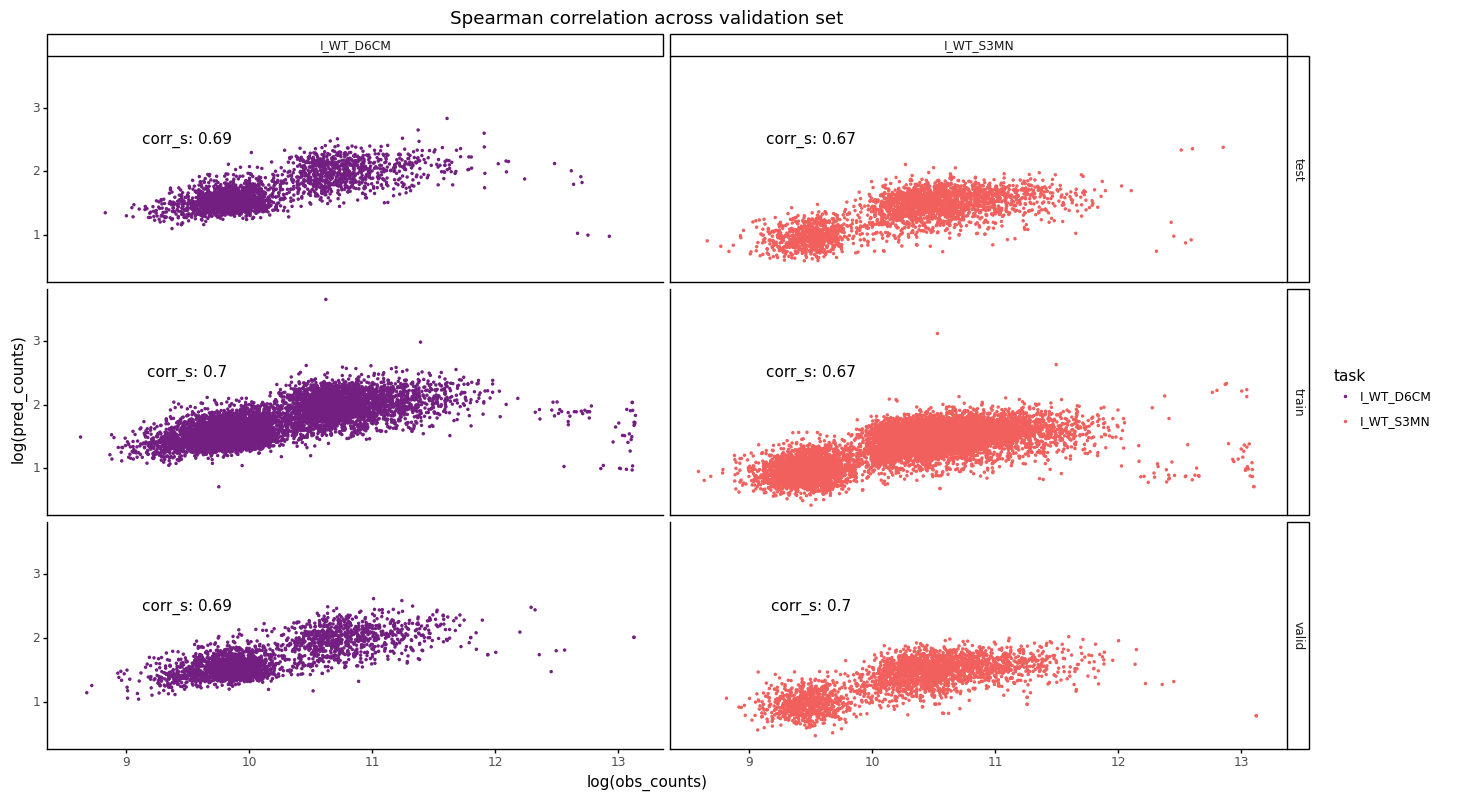

In [21]:
import seaborn as sns
plotnine.options.figure_size = (16,9)

corr_plot = (ggplot(data = counts_df, mapping = aes('obs','pred'))+
    geom_point(aes(color = 'task'), size = .4)+
    geom_text(data = corr_df, mapping = aes(x = 9.5, y = 2.5, label = 'txt'))+
    scale_x_continuous(name = 'log(obs_counts)')+
    scale_y_continuous(name = 'log(pred_counts)')+
    scale_color_manual(values = sns.color_palette('magma', n_colors = len(model.tasks)).as_hex())+
    facet_grid('dataset ~ task')+
    ggtitle(f'Spearman correlation across validation set')+
    theme_classic())

corr_plot.save(f'figures/1_model_training_and_grid_search/figureS3C-corr_all_regions.png', height = 6, width = 8)
corr_plot.save(f'figures/1_model_training_and_grid_search/figureS3C-corr_all_regions.pdf', height = 6, width = 8)
print(corr_plot)

## Calculate replicate and metapeak auPRC 

In [22]:
#Calulcate auPRC values for this model
auprc_df = pd.DataFrame()
for dataset in ['train','valid','test']:
    for task in tqdm(model.tasks):
        binsizes = [10]
        pos_min_threshold=0.0025
        neg_max_threshold=0.001
        required_min_pos_counts=.01

        #Filtering regions such that they belong to the correct task at hand
        task_idx = np.where(data_dict[dataset]['metadata']['interval_from_task'] == f'{task}')[0]
        #task_idx = range(y_obs[f'{task}/profile'].shape[0])

        ##Do this for task-specific windows
        #Observed versus predicted signal
        o_vs_p_df = eval_seq_profile(yt = y_obs_dict[dataset][f'{task}/profile'][task_idx], 
                                     yp = y_pred_dict[dataset][f'{task}'][task_idx],
                                 pos_min_threshold=pos_min_threshold, neg_max_threshold=neg_max_threshold,
                                 required_min_pos_counts=required_min_pos_counts, binsizes=binsizes)
        o_vs_p_df['type']='obs_vs_pred'
        o_vs_p_df['task_specific']='task_specific'

        #Replicate 1 vs replicate 2
        r1_vs_r2_df = eval_seq_profile(yt = np.expand_dims(rep1_obs_dict[dataset][f'{task}'][task_idx], axis = 2), 
                                       yp = np.expand_dims(rep2_obs_dict[dataset][f'{task}'][task_idx], axis = 2),
                                 pos_min_threshold=pos_min_threshold, neg_max_threshold=neg_max_threshold,
                                 required_min_pos_counts=required_min_pos_counts, binsizes=binsizes)
        r1_vs_r2_df['type']='rep1_vs_rep2'
        r1_vs_r2_df['task_specific']='task_specific'

        ## Do this for all windows
        #Observed versus predicted signal
        all_o_vs_p_df = eval_seq_profile(yt = y_obs_dict[dataset][f'{task}/profile'], 
                                         yp = y_pred_dict[dataset][f'{task}'],
                                 pos_min_threshold=pos_min_threshold, neg_max_threshold=neg_max_threshold,
                                 required_min_pos_counts=required_min_pos_counts, binsizes=binsizes)
        all_o_vs_p_df['type']='obs_vs_pred'
        all_o_vs_p_df['task_specific']='all_task_windows'

        #Replicate 1 vs replicate 2
        all_r1_vs_r2_df = eval_seq_profile(yt = np.expand_dims(rep1_obs_dict[dataset][f'{task}'], axis = 2), 
                                       yp = np.expand_dims(rep2_obs_dict[dataset][f'{task}'], axis = 2),
                                 pos_min_threshold=pos_min_threshold, neg_max_threshold=neg_max_threshold,
                                 required_min_pos_counts=required_min_pos_counts, binsizes=binsizes)
        all_r1_vs_r2_df['type']='rep1_vs_rep2'
        all_r1_vs_r2_df['task_specific']='all_task_windows'  

        #Observed versus randomly shuffled signal
        o_vs_r_df = o_vs_p_df.copy()
        o_vs_r_df['auprc'] = o_vs_r_df['random_auprc']
        o_vs_r_df['type']='obs_vs_random'

        #Observed versus randomly shuffled signal
        all_o_vs_r_df = all_o_vs_p_df.copy()
        all_o_vs_r_df['auprc'] = all_o_vs_r_df['random_auprc']
        all_o_vs_r_df['type']='obs_vs_random'

        df = pd.concat([o_vs_p_df, r1_vs_r2_df, o_vs_r_df,
                       all_o_vs_p_df, all_r1_vs_r2_df, all_o_vs_r_df])
        df['task'] = task
        df['dataset'] = dataset
        auprc_df = auprc_df.append(df)
auprc_df

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


,binsize,auprc,random_auprc,n_positives,frac_ambigous,imbalance,type,task_specific,task,dataset
0,10,0.985301,0.093216,16506,0.325636,0.082999,obs_vs_pred,task_specific,I_WT_D6CM,train
0,10,0.980396,0.142721,21055,0.272065,0.148941,rep1_vs_rep2,task_specific,I_WT_D6CM,train
0,10,0.093216,0.093216,16506,0.325636,0.082999,obs_vs_random,task_specific,I_WT_D6CM,train
0,10,0.898482,0.035606,18420,0.455939,0.035370,obs_vs_pred,all_task_windows,I_WT_D6CM,train
0,10,0.980424,0.156034,22450,0.272837,0.148716,rep1_vs_rep2,all_task_windows,I_WT_D6CM,train
0,10,0.035606,0.035606,18420,0.455939,0.035370,obs_vs_random,all_task_windows,I_WT_D6CM,train
0,10,0.982345,0.096314,41013,0.329025,0.090407,obs_vs_pred,task_specific,I_WT_S3MN,train
0,10,0.883771,0.149127,56573,0.287590,0.136398,rep1_vs_rep2,task_specific,I_WT_S3MN,train
0,10,0.096314,0.096314,41013,0.329025,0.090407,obs_vs_random,task_specific,I_WT_S3MN,train
0,10,0.940666,0.083516,43289,0.372781,0.074340,obs_vs_pred,all_task_windows,I_WT_S3MN,train


Plot the auPRC values of actual data for reference.

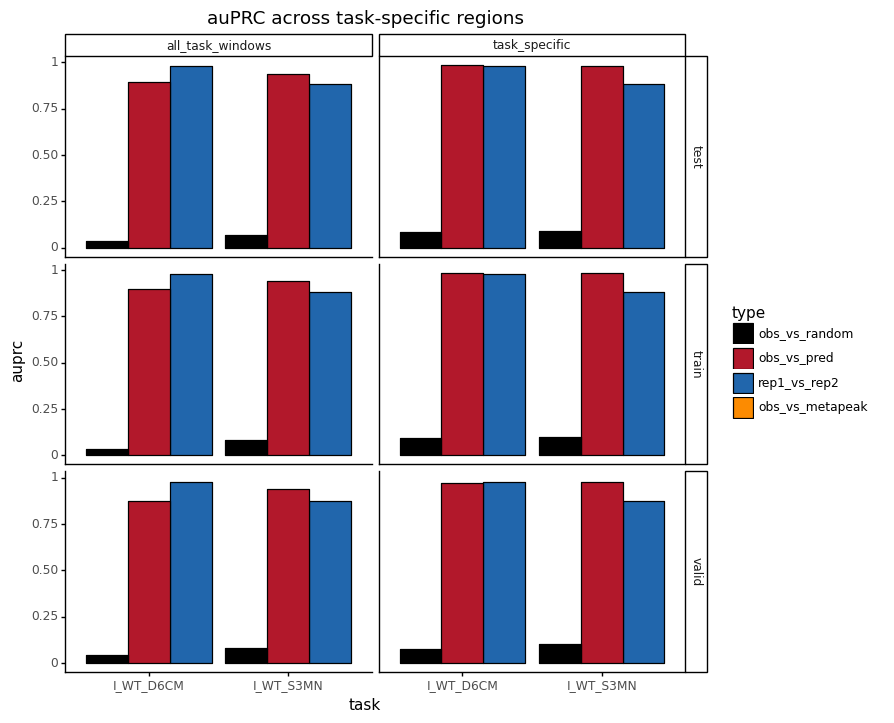

In [23]:
%matplotlib inline
plotnine.options.figure_size = (8,8)

auprc_df['type'] = pd.Categorical(auprc_df['type'], 
                                  categories=['obs_vs_random', 'obs_vs_pred', 'rep1_vs_rep2', 'obs_vs_metapeak'], 
                                  ordered=False)

auprc_plot = (ggplot(data = auprc_df, mapping = aes(x = 'task',y='auprc'))+
    geom_bar(mapping = aes(fill = 'type'), stat = 'identity', position = 'dodge', color = 'black')+
    scale_fill_manual(values = ['#000000', '#b2182b', '#2166ac', '#fc8b01'])+
    facet_grid('dataset ~ task_specific')+
    ggtitle(f'auPRC across task-specific regions')+
    theme_classic())
auprc_plot.save(f'figures/1_model_training_and_grid_search/figureS3C-auprc_all_regions.png', height = 8, width = 8)
auprc_plot.save(f'figures/1_model_training_and_grid_search/figureS3C-auprc_all_regions.pdf', height = 8, width = 8)
print(auprc_plot)